---

## 2η Εργασία <br> Αναγνώριση Προτύπων – Μηχανική Μάθηση <br/>Εαρινό Εξάμηνο 2020-2021


**Ροβιθάκης Ιωάννης - sdi1800164**

---

# References: <br/>
- To make the image plots in **plotImages( )**, I got ideas from this example of the official matplotlib documetation: 
https://matplotlib.org/stable/gallery/text_labels_and_annotations/demo_annotation_box.html#sphx-glr-gallery-text-labels-and-annotations-demo-annotation-box-py

- For **PCA_ImageSpaceVisualization( )**, I followed the exact methodology we were teached on lab 6_1 for eigendecomposition

- For the Kfold cross validation and the NN classifier, i based my code on the examples from the documentation:<br/>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html <br/>
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

Υ.Γ. : Θα ήμουν ευγνώμων, αν κάποια από τις εξηγήσεις μου είναι λανθασμένη και κατα συνέπεια έχω καταλάβει κάτι λάθος, να μου στείλετε ένα email  στο sdi1800164@di.uoa.gr ωστε να διαβάσω το αντίστοιχο κομμάτι ξανά. Ευχαριστώ πολύ.

# Utils / General

In [ ]:
# Imports:
import cv2
import numpy as np
from os import listdir
from statistics import mean
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
from scipy.sparse.linalg import eigsh
import matplotlib.patches as mpatches
from sklearn.model_selection import KFold
from google.colab.patches import cv2_imshow
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

# Drive Mount
from google.colab import drive
drive.mount('/content/gdrive')

# Set Global parameters
data_location = r'/content/gdrive/MyDrive/MachineLearning2021/ML2/images'   # Set the data location
dimentions = (100, 100)                                                     # Set the required dimentions

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Prints all the images in the given list (Used for testing)
def printImages(images):
  for img in images:
    cv2_imshow(img)
    print(img.shape, '\n')

In [ ]:
# Plot the images in the given coordinates
def plotImages(coords):
  fig, ax = plt.subplots()

  # I Set these sizes by trial and error, to make my plot as clear as possible
  fig.set_size_inches(20, 6)
  ax.set_xlim( min(coords[0])*1.05, max(coords[0])*0.6)
  ax.set_ylim( min(coords[1])*1.6, max(coords[1])*1.4)
  #print( "x_max: ", max(coords[0]), "x_min: ", min(coords[0]), "y_max: ", max(coords[1]), "y_min: ", min(coords[1]))

  # For each image in the data, read it, load it and add it to the plot, 
  # using the coordinates from PCA (labels and coords are in the same order)
  for i, item in enumerate(labels):
    img = pltimg.imread(item[0]) 
    offset = OffsetImage(img, zoom=0.25)   
    ab = AnnotationBbox(offset, (coords[0][i], coords[1][i]))
    ax.add_artist(ab)

  plt.draw()
  plt.show()

---
# Ερώτημα 1: Προ-επεξεργασία, μείωση διαστάσεων, οπτικοποίηση και ταξινόμηση 
---

# I)

In [ ]:
# Ι)
# Load the existing images from the given directory and return them in an array
def loadImages(path):
  
  # Get a list of the image_files
  image_files = listdir(path)
  print("> Found %u images\n" % len(image_files))

  resized_images = []   # An array to store the resized images
  labels = []           # An array to store each element's label/category

  # For each image file
  for jpg in image_files:
    img_path = str(path+'/'+jpg)         # Get its path
    img = cv2.imread(img_path)           # Load it
    img = cv2.resize(img, dimentions)    # Resize it
    resized_images.append(img.flatten()) # Flatten And store it (To turn it into a sigle vector without losing any information)

    # Depending on the letter code in the image name, set the correct label id for each image
    # Also add the full image path to the label of each image for later use
    if jpg[0] == 'W':
      labels.append((img_path,0))
    elif jpg[0] == 'F':
      labels.append((img_path,1))
    elif jpg[0] == 'S':
      labels.append((img_path,2))
    else:
      print(" Error: Image with unsupported name format", jpg)
      return (None,None)

  # Return the results in the required formats (transpose to get it in the wanted format)
  return (np.array(resized_images).transpose(), labels)

# II)

In [ ]:
# ΙΙ)
# Prints a plot of the given image vector table
def PCA_ImageSpaceVisualization(X):

  # Start by calculating the covariace of the given array
  covar = np.cov(X)
  #print(X.shape, covar.shape)

  # Then get the eigenvalues and the eigenvectors
  eigValue, eigVector = eigsh(covar)
  # (I used eigsh from scipy because numpy's eigh would run out of ram and crash)
  #print(eigVector.shape)

  # Get the two eigenvectors that correspond to the largest by absolute eigenvalues
  # ( eigsh() returns them already sorted so we just need to get the last 2 of them )
  eigVector = eigVector.transpose()
  size = len(eigVector)
  dim1 = np.array(eigVector[size-1]).reshape(len(eigVector[size-1]), 1)
  dim2 = np.array(eigVector[size-2]).reshape(len(eigVector[size-2]), 1)
  top2 = [dim1, dim2]
  #print(dim1.shape)
  #print(dim1)

  # Based on the found eigenvectors create a transform table
  trans = np.hstack(top2)
  trans = trans.transpose()
  #print(trans.shape)
  #print(trans)

  # Transform the initial array using the found eigenvectors to fit it to the wanted dimentions
  final = trans.dot(X)
  #print(final.shape)

  # We transformed the data to the new dimentions, now plot them
  plotImages(final)
  return final

> Found 30 images



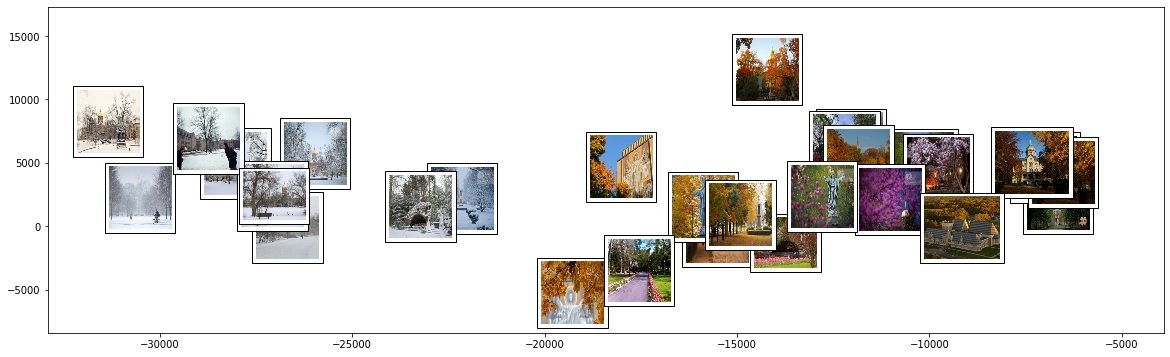

In [ ]:
# Main():

# Get the data as an array and its laybels
images, labels = loadImages(data_location)  
#print(images.shape)                        

# Using PCA with eigendecomposition, we reduce the dimentions of our data and 
# visualize the results to study them
result = PCA_ImageSpaceVisualization(images)

Το σχήμα αποτέλεσμα βγήκε ανάποδο-συμμετρικό από αυτό της εκφώνησης, αναμενόμενο καθώς η eigsh μπορεί σε κάποιες περιπτώσεις να επιστρέψει τις "αντίθετες" ιδιοτιμές. Το σχήμα κατα τα άλλα είναι ακριβώς το ίδιο

# ΙΙΙ)


- Τι σημαίνει όταν εικόνες βρίσκονται κοντά σε αυτό το χώρο δύο διαστάσεων που απεικονίζεται στο παραπάνω plot; 

Το οτι δύο ή περισσότερες εικόνες βρίσκονται κοντά στο παραπάνω διάγραμμα των δύο διαστάσεων, δείχνει ότι στις δύο συνιστώσες στις οποίες παρατηρούνται οι μεγαλύτερες διακυμάνσεις τιμών στα δεδομένα μας, οι εικόνες αυτές είναι όμοιες - έχουν όμοια χαρακτηριστικά.
Πιο απλά, οι εικόνες αυτές ανοίκουν στην ίδια "ομάδα" - "κατηγορία" με βάση τις 
δύο κυρίαρχες συνιστώσες. Στο παράδειγμά μας, οι κυρίαρχες συνιστώσες φαίνεται να σχετίζονται με τα χρώματα, καθώς οι χειμερινές εικόνες βρίσκονται ξεκάθαρα μακριά από τις υπόλοιπες λόγω του μεγάλου ποσοστού λευκού χρώματος που περιέχουν.

- Τι σημαίνει όταν εικόνες απέχουν πολύ;

Αντίστοιχα με παραπάνω, Το οτι δύο εικόνες βρίσκονται μακριά, σημαίνει ότι σε τουλάχιστον μία από τις κύριες συνιστώσες οι εικόνες αυτές απέχουν κατα πολύ, και κατα συνέπεια δυσκολα ανοίκουν στην ιδια "κατηγορία" - κάποια ή όλα τα χαρακτηριστικά τους διαφέρουν σε σημαντικό βαθμό

- Μπορούμε να γενικεύσουμε αυτά τα συμπεράσματα για τον αρχικό χώρο των εικόνων ο οποίος είναι πολύ μεγάλης διάστασης;

Από την θεωρία του μαθήματος, έχουμε δείξει μέσω παραδειγμάτων οτι σε χώρους μεγάλων διαστάσεων, όπως ο αρχικός στο παράδειγμα αυτό, είναι εξαιρετικά δύσκολο έως αδύνατο να κάνουμε γενικεύσεις, και οι οπτικοποιήσεις είναι πρακτικά αδύνατες. Με βάση την δική μου κατανόηση, σε πολύ μεγάλους χώρους, λόγω της πληθώρας ανεπεξέργαστων δεδομένων, λαμβάνουμε υπ'όψην μας και χαρακτηριστικά των δεδομένων χαμηλής σημασίας αντί να εστιάσουμε στα πιο σημαντικά (Όπως έχουμε δει, σε πολλές περιπτώσεις, πολύ λίγα χαρακτηριστικά είναι αρκετά για επίτευξη εξαιρετικής ακρίβειας ή καποια χαρακτηριστικά να μην παίζουν κανέναν απολύτως ρόλο στο πρόβλημα μας και να δρούν 'παραπλανητικά'). Ακόμα και στην ακραία περίπτωση που όλα τα χαρακτηριστικά είναι εξίσου σημαντικά για το μοντέλο μας, σε χώρους μεγάλων διαστάσεων, ερχόμαστε αντιμέτωποι με υπολογιστικά προβλήματα και κυριολεκτικά "αδύνατες" πολυπλοκότητες χρόνου ή/και μνήμης για τους σημερινούς υπολογιστές.

# ΙV)

- Οι εικόνες που αντιστοιχούν σε μία από τις εποχές τείνουν να ομαδοποιούνται πιο κοντά από ότι οι υπόλοιπες; 

Όντως, σε μεγάλο βαθμό, εικόνες που βρίσκονται κοντά στο παραπάνω διάγραμμα, συνήθως ανοίκουν στην ίδια ομάδα-κλάση

- Γιατί συμβαίνει αυτό;

Όπως είδαμε και παραπάνω, οι 2 κυρίαρχες συνιστώσες φαίνεται να σχετίζονται με τα χρώματα στην περίπτωσή μας. Συνεπώς, είναι λογικό εικόνες με παρόμοια χρώματα σε παρόμοιες φωτεινότητες και αποχρώσεις να πέφτουν σε ίδιες κατηγορίες.
Στο παράδειγμά μας, παρατηρούμε εναν ξεκάθαρο διαχωρισμό των εικόνων του χειμώνα, λόγω της υπεροχής του λευκού χρώματος, ενώ βλέπουμε έναν λιγότερο ξεκάθαρο διαχωρισμό μεταξύ φθινοπώρου και άνοιξης. Παρόλα αυτά, σε αρκετά σημεία, η παρουσία και τα έντονα χρώματα των λουλουδιών, ερχονται σε αντίθεση με τα πορτοκαλί-κοκκινα χρώματα του φθινοπώρου που οδηγεί σε κάποιο βαθμό σε μικρες-πολύ τοπικές ομαδοποιήσεις. Θα ήταν ενδιαφέρον να κάνουμε το ίδιο πείραμα από την αρχή, αλλά χωρίς τις εικόνες του χειμώνα για να δούμε αν θα εμφανιστεί καλύτερος διαχωρισμός μεταξύ φθινοπόρου και άνοιξης.

# V)

V.2) Όπως έχουμε δεί στη θεωρία του μαθήματος, με την PCA, μειώνουμε τις διαστάσεις των δεδομένων μας με σκοπό να εστιάσουμε στο πιο σημαντικό κομμάτι των πληροφοριών. Στην μείωση διαστάσεων αυτή ομως, όσο αφαιρούμε διαστάσεις, τόσο χάνουμε ενα ποσοστό πληροφορίας. Στην άσκηση αυτή, θέλουμε να βρούμε το πλήθος διαστάσεων που να επιτυγχάνει την καλύτερη δυνατή ακρίβεια με το μικρότερο δυνατό πλήθος διαστάσεων. Συνεπώς πρέπει με κάποιο τρόπο να μετρήσουμε πόση πληροφορία περίπου περιέχεται στην κάθε διάσταση. Ένας απλός τρόπος να το κάνουμε αυτό, είναι να υπολογίσουμε το ποσοστό του συνολικού variation που υπάρχει σε κάθε διάσταση. Αφού οι ιδιοτιμές είναι μεγαλύτερες κατ' απόλυτη τιμή, όσο μεγαλύτερο είναι το variation του κάθε ιδιοδιανύσματος, αρκεί να πάρουμε το ποιλίκο της κάθε ιδιοτιμής προς το άθροισμα όλων των ιδιοτιμών, και έχουμε μια μετρική για το πόση πληροφορία-variation από την συνολική διαθέσιμη υπάρχει στην κάθε διασταση. Ιδανικά, θέλουμε το ελάχιστο δυνατό πλήθος διαστάσεων που να επιτυγχάνει ακρίβεια αναπαράστασης της αρχικής πληροφορίας περίπου στο 90%.

In [ ]:
# We need to compare the initial dimention data with the PCA of the dimention that we will judge the most accurate
# Consequently we first need to find the optimal component amount for PCA:
# As explained above, we will calculate the amount of information represented on each component using
# its eigenvalue / the total sum of all the eigenvalues, to keep the minimum amount of components
# that give us the least amount of data loss

# Starting from the initial 100x100 data, we will get its covariance table and then its eigenvalues
covar = np.cov(images)
eigValue, eigVector = eigsh(covar)

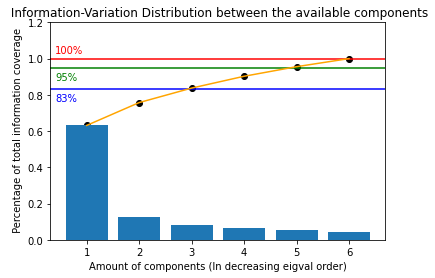

In [ ]:
# We get the total sum of the eigenvalues
eigsum = sum(abs(eigValue))
#print(eigsum)

# Then we calculate the individual "information-percentages"
infperc = []
for eigv in eigValue:
  infperc.append( eigv/eigsum )

# Reverse both lists to get them in decreasing order
eigvlist = list(eigValue)
eigvlist = eigvlist[::-1]
infperc = infperc[::-1]
# print(len(eigvlist))
# print(len(infperc))

# Get the cumulative sum of the percentages to visualize how much 
# variation coverage we can achieve with every extra component
cum = np.cumsum(infperc)

# And plot them to see how the information-variation percentages are distributed 
# Between the available components
plt.axhline(y=1, color='r')
plt.text(0.4, 1.03, '100%', color = 'r')

plt.axhline(y=0.95, color='g')
plt.text(0.4, 0.88, '95%', color = 'g')

plt.axhline(y=0.83, color='b')
plt.text(0.4, 0.765, '83%', color = 'b')

plt.plot(range(1, len(eigvlist)+1), cum, color='orange')
plt.bar(range(1, len(eigvlist)+1), infperc)
plt.scatter(range(1, len(eigvlist)+1), cum, color='black')

plt.title(' Information-Variation Distribution between the available components')
plt.ylabel(' Percentage of total information coverage')
plt.xlabel('Amount of components (In decreasing eigval order)')
plt.ylim([0, 1.2])
plt.show()

Όπως φαίνεται στο παραπάνω σχήμα, περίπου το 65% της πληροφορίας-variation βρισκεται μόλις σε μία συνιστώσα. Η προσθήκη της 2ης προσθέτει περίπου 10%, ενώ κάθε επόμενη προσθήκη, προσθέται περίπου 5% ακόμα.
Για την συνέχεια αυτής της άσκησης, αποφάσισα να χρησιμοποιήσω 3 διαστάσεις (~83% της πληροφορίας) με την λογική οτι απο την μια παρέχουν μια καλή ισορροπία ακρίβειας/μεγέθους, ενω ταυτόχρονα μπορώ να προσπαθήσω να το οπτικοποιήσω για προσωπικό μου πειραματισμό (Αφού ειναι 3 διαστασεις μονο). Αν στην πορεία δω οτι το 83% δεν αρκει, απλά θα προσθέσω διαστάσεις μέχρις ότου τα αποτελέσματα να είναι ικανοποιητικά για τις απαιτήσεις της άσκησης. 

In [ ]:
# Return an array of the top N eigenvectors
def getTopN(eigVector, N):
  eigVector = eigVector.transpose()

  topN = []
  count = 0
  # Pass all the eigenvectors from last to first (since they are in descending order)
  # And keep only the N largest ones
  for i in range(len(eigVector)-1, -1, -1):
    topN.append(np.array(eigVector[i]).reshape(len(eigVector[i]), 1))
    count += 1
    if count == N:
      break

  # Based on the found eigenvectors create a transform table
  trans = np.hstack(topN)
  trans = trans.transpose()
  #print(trans.shape)
  return trans

In [ ]:
# We will now transform our data to the dimention we selected
componentAmount = 3

# Get the transform table
trans = getTopN(eigVector, componentAmount)

# Transform the initial array using the found eigenvectors to fit it to the wanted dimentions
reduced = trans.dot(images)
print(reduced.shape)

(3, 30)


V.1) Στην πράξη, θέλουμε να συγκρίνουμε την μέθοδο του κοντινότερου γείτονα, για έναν, εναντίον τριών γειτόνων, και αυτό αντίστοιχα τόσο για τα αρχικά δεδομένα μας, όσο και για τα δεδομένα χαμηλής διάστασης που προκύπτουν από την παραπάνω PCA.

Για το 5-fold cross validation, ακολουθούμε ακριβώς την διαδικασία που έχουμε διδαχθεί στην θεωρία του μαθήματος. Στην πράξη, αρχικά χωρίζουμε τα δεδομένα μας σε 5 -τυχαία- γκρούπ/folds, και στη συνέχεια επαναληπτικά εκπαιδεύουμε το μοντέλο μας με τα 4, και μετράμε την ακρίβεια του με το 5ο (διαφορετικό 5ο κάθε φορά) μέχρι να έχουν χρησιμοποιηθεί όλα τα folds για δοκιμές. Από τις δοκιμές αυτές κρατάμε την μέση ακρίβεια, η οποία είναι και το αποτέλεσμα του πειράματος μας. Από πλευρά λογικής, ειναι σε γενικές γραμμές μια αρκετα αξιόπιστη "στατιστική" μεθοδος για την μέτρηση της ακρίβειας ενός μοντέλου/μεθόδου στα δεδομένα μας.

In [ ]:
# Keep only the labels from this tuple list
def onlyLabels(labelList):
  labels = []
  for i in labelList:
    labels .append(i[1])
  print(labels)
  return np.array(labels)

In [ ]:
# Returns k folds of the given data
def split(data, k):
  kf = KFold(n_splits=k)
  kf.get_n_splits(data)
  return kf

In [ ]:
# Since it is allowed from the assignment, i fitted my data to the format of the
# built-in sklearn functions and used them for my tests

# Bring the data to the format it is required for the sklearn functions
initial_data = images.transpose()
reduced_data = reduced.transpose()
labels_data = onlyLabels(labels)
print(initial_data.shape, reduced_data.shape, labels_data.shape)

[0, 2, 0, 2, 0, 2, 2, 0, 1, 0, 2, 0, 1, 1, 0, 2, 0, 0, 1, 1, 2, 2, 0, 1, 1, 2, 1, 2, 1, 1]
(30, 30000) (30, 3) (30,)


In [ ]:
splitAmount = 5
# Trains a k-NN model using the given data, and then calculates its accuracy
def testMethod(data, laybels, k):

  # Using the built-in sklearn k-fold cross validation function, split our data to folds
  kf = KFold(n_splits=splitAmount)

  scores = []

  # Perform a test for each of the available folds
  for train_index, test_index in kf.split(data):

    # Get the correct folds for this loop
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = laybels[train_index], laybels[test_index]

    # Create a KNN classifier using sklearn
    neigh = KNeighborsClassifier(n_neighbors=k)

    # Fit the training data to it
    neigh.fit(X_train, y_train)

    # Test the model using the test data
    scores.append( neigh.score(X_test, y_test) )

  # After all the tests are complete, return the average accuracy between all the tests
  #print(scores)
  return mean(scores)

0.7 0.6666666666666666 0.7 0.6666666666666666


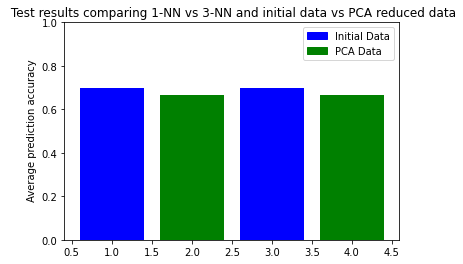

In [ ]:
# Now we will perform our tests to compare the methods
test1 = testMethod(initial_data, labels_data, 1)
test2 = testMethod(reduced_data, labels_data, 1)
test3 = testMethod(initial_data, labels_data, 3)
test4 = testMethod(reduced_data, labels_data, 3)
print( test1, test2, test3, test4)

# And Plot the results
initial_results = [test1, test3]
initial_pos = [1, 3]

reduced_results = [test2, test4]
reduced_pos = [2, 4]

plt.bar(initial_pos, initial_results, color='b')
plt.bar(reduced_pos, reduced_results, color='g')

blue_patch = mpatches.Patch(color='b', label='Initial Data')
green_patch = mpatches.Patch(color='g', label='PCA Data')
plt.legend(handles=[blue_patch, green_patch])
plt.title(' Test results comparing 1-NN vs 3-NN and initial data vs PCA reduced data')
plt.ylabel(' Average prediction accuracy')
plt.ylim([0, 1])
plt.show()

Είναι εντυπωσιακό το πως μειώνοντας τόσο δραστικά τις διαστάσεις των αρχικών δεδομένων, 'χάνοντας' αρκετή πληροφορία, συνεχίζουμε με μόλις 3 συνιστώσες να έχουμε ακρίβεια πολύ κοντά σε αυτή της αρχικής πληροφορίας. Στην περίπτωση μας φαίνεται να μην υπάρχει σημαντικός διαχωρισμός μεταξύ 1ΝΝ και 3ΝΝ, αλλα στις δοκιμές μου 1ΝΝ νs 5NN υπάρχει εντυπωσιακή διαφορά (δοκιμάστε το ο κώδικας είναι δυναμικός) και με τα δεδομένα μειωμένης διάστασης προσπερνάμε κατα πολύ τα αρχικά. Περίμενα έστω και μικρό διαχωρισμό μεταξύ 1ΝΝ και 3ΝΝ αλλα δεν τον είδα.

---
# Ερώτημα 2: - Κανονικοποιημένη μη-αρνητική παραγοντοποίηση πινάκων 
---

# I)

Στο σημείο αυτό, παραθέτω τις ιδιότητες που χρησιμοποιώ στις πράξεις μου παρακάτω, αριθμημένες για μια πιο καθαρή απόδειξη: <br/>( Oι αριθμοί που ακολουθούν κάθε ιδιότητα αντιστοιχούν στους αριθμούς σχέσεων στο "The Matrix Cookbook" - **TMC** )<br/> <br/>

(1) Derivative of Frobenius Norm<br/>
$\frac{\partial}{\partial X} ||X||_{F}^{2} = \frac{\partial}{\partial X} Tr(XX^T)$ : (TMC 132)<br/> <br/>

(2) ${\partial (X+Y) } = ({\partial X} + {\partial Y})$ : (TMC 35)<br/> <br/>

(3) $(A + B)^T = A^T + B^T$ : (TMC 4)<br/> <br/>

(4) $(AB)^T = B^TA^T$ : (TMC 5)<br/> <br/>

(5) $ Tr(A+B) = Tr(A) + Tr(B)$ : (TMC 15)<br/> <br/>

(6) $ Tr(AB) = Tr(BA)$ : (TMC 14)<br/> <br/>

και αντίστοιχα: $ Tr(ABC) = Tr(BCA) = Tr(CAB)$ : (TMC 16)<br/> <br/>

(7) $ \frac{\partial}{\partial X} Tr(AXB) = A^TB^T$ : (TMC 101)<br/> <br/>

(8) $ \frac{\partial}{\partial X} Tr(AX^TB) = BA$ : (TMC 102)<br/> <br/>

(9) $ \frac{\partial}{\partial X} Tr(XBX^T) = XB^T + XB$ : (TMC 111)<br/> <br/>

(10) $ \frac{\partial}{\partial X} Tr(XBB^TX^T) = Tr(X (BB^T) X^T) =^{(9)} X(BB^T)^T + X(BB^T) = XBB^T + XBB^T = 2XBB^T$

![](https://drive.google.com/uc?export=view&id=1oSMRxW5lJz6MCmKSacFi9WYbDE2dffxD) 

![](https://drive.google.com/uc?export=view&id=1Y3gOIXf6jTFrHqy9KnF5pytoEtlyuDRz) 

![](https://drive.google.com/uc?export=view&id=1YzXIAcjhiOlhzbmzkaw9vryj_XA9MAC1) 

![](https://drive.google.com/uc?export=view&id=1xGRlj7VHpoOlTXtsc6OyUmKkeYf5QZGi)


#II)

Με βάση όσα έχουμε κάνει στο εργαστήριο 6_2, και από τους επαναληπτικούς τύπους που βρήκαμε στο ερώτημα Ι, έχουμε:

In [ ]:
# Define the test parameters
l_tests = [0.5]
k_tests = [5, 10, 50]
e_tests = [0.1, 0.01, 0.001]
max_iterations = 2000
rand_seed = 164 # I used my sdi as a seed for consistent results

In [ ]:
# Create the test data:

# Create the two sub-matrices
np.random.seed(rand_seed)
W = np.random.rand(500,10)
H = np.random.rand(10,500)

# "Merge" them
X = W.dot(H)
print(X.shape)

# Ensure that the final matrix is positive
X = abs(X)

(500, 500)


In [ ]:
# Return the frobenius norm as required from the assignment types
def frobenius_norm(X,A,B):
  error = np.linalg.norm(X - np.dot(A, B), 'fro')**2
  error /= np.linalg.norm(X, 'fro')**2
  return error

# Update the Matrix A based on the previously found multiplicative update rule
def update_A(X,A,B,l):
  numerator = X.dot(B.T)
  denominator = A.dot(B.dot(B.T)) + l*A
  A *= numerator
  A /= denominator
  return A

# Update the Matrix B based on the previously found multiplicative update rule
def update_B(X,A,B):
  numerator = np.dot(A.T, X)
  denominator = np.dot(A.T.dot(A), B )
  B *= numerator
  B /= denominator
  return B

In [ ]:
# This function is based on the lab 6_2 code
# I changed the parameter name from 'lambda' to l because it is used by python itself

# Perform regularized non-negative matrix factorization on the given matrix
def RegNMF(X,k,l,epsilon):

  # Start from random matrices 
  # (Seed them to have consistent behaviors between tests with different parameters)
  h, w = X.shape
  np.random.seed(rand_seed)
  A = np.random.random((h, k))
  B = np.random.random((k, w))
  frob_error = np.zeros(max_iterations)
  iterations = max_iterations

  # Start the main loop, and update the matrices until you satisfy the tolerance of run out of iterations
  for i in range(max_iterations):

    # Update the matrices using the multiplicative update rules we found previously
    A=update_A(X,A,B,l)
    B=update_B(X,A,B)

    # Calculate the iteration error
    frob_error[i] = frobenius_norm(X,A,B)
    #print(frob_error[i])

    # If the error is acceptable for our given tolerance, we return the results
    if ((i>0) and (abs(frob_error[i-1] - frob_error[i]) <= epsilon)):
      print("     %f  -  %f   =  %f" % (frob_error[i-1], frob_error[i], abs(frob_error[i-1] - frob_error[i])))
      iterations = i;
      break

  # Exited by 'break' or Run out of iterations 
  return (A,B,frob_error, iterations)

In [ ]:
# Print the initial matrix to have a point of comparison
print(" (i) Initial Matrix:\n", X, "\n -----------------------------------------------------------------\n")

# Run the tests
for l in l_tests:
  for k in k_tests:
    for e in e_tests:
      print(" (i) Testing for: l=%f, k=%f, e=%f" % (l,k,e))
      A, B, E, I= RegNMF(X,k,l,e) 
      print("     Completed in %d iterations" % I)
      print( A.dot(B) )
      #print( np.linalg.norm(X - np.dot(A, B), 'fro')**2 + l* np.linalg.norm(A, 'fro')**2)
      #print(E)
      print('\n')

 (i) Initial Matrix:
 [[1.46294357 2.45334237 2.4248868  ... 1.65724202 1.96057184 2.54053388]
 [2.20768451 2.54751891 2.33673647 ... 2.0716245  1.71870264 2.32565835]
 [2.01201119 3.24939602 2.82134215 ... 2.47967702 2.3550429  2.8530105 ]
 ...
 [1.70959755 1.3311803  1.73471334 ... 1.37926489 1.23527513 1.93962375]
 [1.95186037 1.96674717 2.19244633 ... 1.77109399 2.08234443 2.36806581]
 [2.70305236 2.77419999 3.66685412 ... 2.0750544  2.3741076  2.178521  ]] 
 -----------------------------------------------------------------

 (i) Testing for: l=0.500000, k=5.000000, e=0.100000
     0.031187  -  0.027416   =  0.003771
     Completed in 1 iterations
[[1.83679014 2.34928783 2.32199701 ... 1.92726405 1.92539177 2.33407714]
 [1.93086667 2.80876717 2.250351   ... 2.1257079  2.00672774 1.78119457]
 [2.5019781  1.78458901 2.87896959 ... 2.00008635 2.51043633 3.08630846]
 ...
 [1.35859577 2.14576786 1.66976203 ... 1.5953368  1.28617798 1.59674157]
 [2.08185845 1.71074492 2.34215674 ... 1.27

# Σχολιασμός:


Με βάση την κατανόηση μου, με τον NMF, σκοπός μας είναι να βρούμε δύο πίνακες Α και Β, των οποίων το γινόμενο προσεγγίζει τον αρχικό μας πίνακα Χ. Αυτοί οι πίνακες, μας επιτρέπουν να απομονώσουμε χαρακτηριστικά του πίνακα Χ (Το k στην περίπτωση μας) τα οποία μπορούμε στην συνέχεια να χρησιμοποιήσουμε σε οποιδήποτε πρόβλημα δουλέυουμε. Με λίγα λόγια μειώνουμε και εδώ τις διαστάσεις του αρχικού πίνακα Χ, κρατώντας κάποια χαρακτηριστικά, με την επιπλέον ιδιότητα ότι θέλουμε οι πίνακες που θα βρούμε να είναι αυστηρά θετικοί (όπως το αντιλαμβάνομαι σε κάποιες περιπτώσεις οι αρνητικές τιμές είναι απαγορευτικές, πχ σε εικόνες δεν υπάρχει αρνητική τιμή rgb). <br/>

Στα αποτελέσματα μας, όπως βλέπουμε όντως πετυχαίνουμε τον στόχο μας να προσεγγίσουμε στον πίνακα Χ. Η τιμή του k, δεν φαίνεται να επηρεάζει το αποτέλεσμα (ή το επηρεάζει ελάχιστα), γεγονός που μου φαίνεται λογικό καθώς δεν λαμβάνει άμεσα ρόλο στις πράξεις, αλλά μόνο στην απομόνωση χαρακτηριστικών. Το ε, στα παραδείγματα που ζητούνται τουλάχιστον και για τα διάφορα seed που δοκίμασα, επίσης δεν φαίνεται να παίζει σημαντικό ρόλο καθώς η ακρίβεια των αποτελεσμάτων μου δεν είναι ικανοποιητική κατα την γνώμη μου. Σε κανονικές συνθήκες, περιμένουμε όσο μικραίνει το ε, τόσο να θέλουμε περισσότερες επαναλήψεις για να καταλήξουμε σε αποδεκτό αποτέλεσμα, και τόσο πιο ακριβές αποτέλεσμα να βρίσκουμε. Στην περίπτωση μας, φαίνεται να "είμαστε τυχεροί" και να βρισκόμαστε απο την 1η επανάληψη πολύ κοντα στην επιθυμητή ακρίβεια. Ισως έχω κάνει κάποιο λάθος στην υλοποίηση μου ή έχω καταλάβει κάτι λάθος και κατα συνέπεια δεν βλέπω το λάθος. Από δοκιμές με πολύ μικρά ε, φαινεται πάντως όντως να βελτιώνεται η ακρίβεια, ακομα και όχι στα επίπεδα που θα ήθελα. Από την άλλη μιλάμε για έναν πίνακα 500x500, και σε μια επανάληψη μονο έχουμε μια αξιοπρεπή προσέγγιση, οπότε μπορει και να είναι όλα οκ. Προσωπικά, θα ήθελα να δοκιμάσω διαφορετικές μετρικες για τερματισμό (πχ κάτι τύπου |Χ - ΑΒ| <= ε) που ίσως να απέφεραν καλύτερα αποτελέσματα σε λίγες παραπάνω επαναλήψεις?

Σας παρακαλώ σε περίπτωση που έχω καταλάβει κάτι λάθος στείλτε μου ενα email για να το ξαναδιαβάσω, δεν θέλω να αφήσω κενά-λάθη στις γνώσεις μου.